## Preparation

### Download the optimization support library package

In [1]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Connect to Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Import Libraries

In [3]:
# Library to support working with data
import numpy as np
import pandas as pd

# Graphing support library
import matplotlib.pyplot as plt

# Data Normalization Support Library
from sklearn.preprocessing import MinMaxScaler

# Library to support building Temporal Convolutional Attention Networks models
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Layer, RepeatVector, concatenate, Reshape, Input, Concatenate, Permute, Multiply, Add, Activation

# Performance metrics calculation support library
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error

# Parameter optimization support library
import optuna

# Support library to ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Support library to load models and data
from keras.utils import custom_object_scope
from tensorflow.keras.models import load_model

## Data preprocessing

### Read data

In [4]:
# Load data
df = pd.read_csv('CTLT.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-02,30.860001,31.260000,30.240000,30.910000,30.910000,1201700
1,2019-01-03,30.660000,30.660000,29.290001,29.840000,29.840000,1149900
2,2019-01-04,30.049999,31.360001,29.940001,31.080000,31.080000,3530400
3,2019-01-07,31.020000,32.180000,30.850000,32.000000,32.000000,1063400
4,2019-01-08,32.340000,33.060001,32.150002,32.790001,32.790001,1391000
...,...,...,...,...,...,...,...
1114,2023-06-06,37.910000,39.049999,37.580002,38.820000,38.820000,2261700
1115,2023-06-07,39.160000,40.029999,38.250000,39.959999,39.959999,4382500
1116,2023-06-08,39.700001,39.840000,36.750000,39.000000,39.000000,9705500
1117,2023-06-09,39.250000,40.110001,38.480000,38.810001,38.810001,4493800


### Reset index

In [5]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'Date' column as the index value
df.set_index('Date', inplace=True)

In [6]:
# Select column 'Close'
df_Close = df[['Close']]
df_Close = df_Close.reset_index(drop=True)

### Data normalization

In [7]:
# Min-max normalization
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(np.array(df_Close))

### Data splitting

In [8]:
# Split the data into train, validation, and test dataset in a ratio of 7:1:2
train_size = int(len(data_scaled) * 0.7)
val_size = int(len(data_scaled) * 0.1)
test_size = len(data_scaled) - train_size - val_size

train_data = data_scaled[: train_size]
val_data = data_scaled[train_size : train_size + val_size]
test_data = data_scaled[train_size + val_size :]

## Model training and testing

In [9]:
# Generating data using the window sliding method
def create_dataset(data, window_size):
    windows, targets = [], []
    for i in range(len(data) - window_size - 1):
        windows.append(data[i : (i + window_size), 0])
        targets.append(data[i + window_size, 0])
    return np.array(windows), np.array(targets)

### Building TCANs model

In [10]:
# Constructing sparse attention layer
class AttentionLayer(Layer):
    def __init__(self, attention_dim):
        super(AttentionLayer, self).__init__()
        self.attention_dim = attention_dim

    def build(self, input_shape):
        self.W1 = Dense(units=self.attention_dim, activation='tanh')
        self.W2 = Dense(units=1, activation='linear')
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        score = self.W2(self.W1(x))
        score = Flatten()(score)
        score = Activation('softmax')(score)
        score = RepeatVector(x.shape[-1])(score)
        score = Permute([2, 1])(score)
        return Multiply()([x, score])

    def compute_output_shape(self, input_shape):
        return input_shape

In [11]:
# Build TCAN model
def build_tcan(window_size, input_dim=1, tcn_filters=64, tcn_kernel_size=2, dropout_rate=0.2, attention_dim=16):
    inputs = Input(shape=(window_size, input_dim))
    x = inputs
    x = Conv1D(filters=tcn_filters, kernel_size=tcn_kernel_size, padding='same', activation='relu')(x)
    x = SpatialDropout1D(rate=dropout_rate)(x)
    x = Conv1D(filters=tcn_filters, kernel_size=tcn_kernel_size, padding='same', activation='relu')(x)
    x = SpatialDropout1D(rate=dropout_rate)(x)

    # Additive Attention
    att = AttentionLayer(attention_dim)(x)
    max_pool_att = GlobalMaxPooling1D()(att)
    max_pool_x = GlobalMaxPooling1D()(x)
    x = concatenate([max_pool_att, max_pool_x])

    outputs = Dense(1)(x)

    model = Model(inputs=inputs, outputs=outputs)
    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='mean_absolute_error', optimizer=optimizer)

    return model

### Learning process with combined parameter optimization

In [12]:
# Initialization of optimization parameters
best_mse = float('inf')
best_model = None
best_window_size = None
best_train_windows = None
best_train_targets = None
best_test_windows = None
best_test_targets = None
best_val_windows = None
best_val_targets = None
best_y_pred = None
best_mape = np.inf
best_rmse = np.inf
best_msle = np.inf

In [13]:
# Define the objective function for Optuna optimization
def objective(trial):
  global best_mse, best_model, best_window_size, best_train_windows
  global best_train_targets, best_test_windows, best_test_targets, best_val_windows
  global best_val_targets, best_y_pred, best_mape, best_rmse, best_msle

  # Define the search space for hyperparameters
  window_size = trial.suggest_int("window_size", 10, 100)
  tcn_filters = trial.suggest_int("tcn_filters", 32, 128)
  tcn_kernel_size = trial.suggest_int("tcn_kernel_size", 2, 5)
  dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
  attention_dim = trial.suggest_int("attention_dim", 8, 32)

  # Build the TCAN model with the suggested hyperparameters
  model = build_tcan(window_size,
                     tcn_filters = tcn_filters,
                     tcn_kernel_size = tcn_kernel_size,
                     dropout_rate = dropout_rate,
                     attention_dim = attention_dim)

  train_windows, train_targets = create_dataset(train_data, window_size)
  val_windows, val_targets = create_dataset(val_data, window_size)
  test_windows, test_targets = create_dataset(test_data, window_size)

  # Train the model
  early_stop = EarlyStopping(monitor='val_loss', patience=5)
  model.fit(train_windows, train_targets,
            epochs=50, batch_size=32,
            validation_data=(val_windows, val_targets),
            shuffle=False, callbacks=[early_stop], verbose=0)

  # Testing the model on Test dataset
  y_pred = model.predict(test_windows)

  # Evaluate on MAPE, RMSE, MSLE
  temp_test_targets = test_targets
  temp_test_targets = scaler.inverse_transform(temp_test_targets.reshape(-1, 1))
  y_pred = scaler.inverse_transform(y_pred)

  mse = mean_squared_error(temp_test_targets, y_pred)
  rmse = np.sqrt(mse)
  mape = mean_absolute_percentage_error(temp_test_targets, y_pred)
  msle = mean_squared_log_error(temp_test_targets, y_pred)

  # Save the best model and related information
  if mse < best_mse or best_mse is None:
    best_model = model
    best_window_size = window_size
    best_y_pred = y_pred
    best_train_windows = train_windows
    best_train_targets = train_targets
    best_test_windows = test_windows
    best_test_targets = test_targets
    best_val_windows = val_windows
    best_val_targets = val_targets
    best_rmse = rmse
    best_mape = mape
    best_msle = msle
    best_mse = mse

  return mse

In [14]:
# Define the search space for the hyperparameters
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

[I 2023-06-14 04:45:42,014] A new study created in memory with name: no-name-0df43188-4ace-4720-96b8-ca3af3905abd


7/7 [==============================] - 1s 5ms/step


[I 2023-06-14 04:45:51,660] Trial 0 finished with value: 54.57924039504578 and parameters: {'window_size': 12, 'tcn_filters': 51, 'tcn_kernel_size': 2, 'dropout_rate': 0.3843024151543949, 'attention_dim': 30}. Best is trial 0 with value: 54.57924039504578.


6/6 [==============================] - 0s 6ms/step


[I 2023-06-14 04:46:15,681] Trial 1 finished with value: 128.56046554798954 and parameters: {'window_size': 35, 'tcn_filters': 70, 'tcn_kernel_size': 2, 'dropout_rate': 0.3905562713315037, 'attention_dim': 21}. Best is trial 0 with value: 54.57924039504578.


7/7 [==============================] - 0s 6ms/step


[I 2023-06-14 04:46:28,316] Trial 2 finished with value: 33.21572735516425 and parameters: {'window_size': 16, 'tcn_filters': 105, 'tcn_kernel_size': 5, 'dropout_rate': 0.42756910138111404, 'attention_dim': 12}. Best is trial 2 with value: 33.21572735516425.


6/6 [==============================] - 0s 5ms/step


[I 2023-06-14 04:46:35,679] Trial 3 finished with value: 253.62278003846868 and parameters: {'window_size': 33, 'tcn_filters': 57, 'tcn_kernel_size': 5, 'dropout_rate': 0.39110657261716, 'attention_dim': 12}. Best is trial 2 with value: 33.21572735516425.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 04:46:39,734] Trial 4 finished with value: 106.52537195069102 and parameters: {'window_size': 25, 'tcn_filters': 67, 'tcn_kernel_size': 5, 'dropout_rate': 0.383742753910549, 'attention_dim': 25}. Best is trial 2 with value: 33.21572735516425.


6/6 [==============================] - 0s 6ms/step


[I 2023-06-14 04:46:52,384] Trial 5 finished with value: 444.8699323036427 and parameters: {'window_size': 57, 'tcn_filters': 78, 'tcn_kernel_size': 5, 'dropout_rate': 0.20265130683321844, 'attention_dim': 24}. Best is trial 2 with value: 33.21572735516425.


5/5 [==============================] - 0s 14ms/step


[I 2023-06-14 04:47:11,358] Trial 6 finished with value: 342.7983835916495 and parameters: {'window_size': 78, 'tcn_filters': 122, 'tcn_kernel_size': 5, 'dropout_rate': 0.23686292852951796, 'attention_dim': 22}. Best is trial 2 with value: 33.21572735516425.


6/6 [==============================] - 0s 5ms/step


[I 2023-06-14 04:47:23,575] Trial 7 finished with value: 210.90877104926844 and parameters: {'window_size': 63, 'tcn_filters': 45, 'tcn_kernel_size': 3, 'dropout_rate': 0.14253297986646649, 'attention_dim': 16}. Best is trial 2 with value: 33.21572735516425.


6/6 [==============================] - 0s 6ms/step


[I 2023-06-14 04:47:35,740] Trial 8 finished with value: 81.37465655558047 and parameters: {'window_size': 37, 'tcn_filters': 79, 'tcn_kernel_size': 2, 'dropout_rate': 0.3151851255677865, 'attention_dim': 12}. Best is trial 2 with value: 33.21572735516425.


6/6 [==============================] - 0s 9ms/step


[I 2023-06-14 04:47:43,052] Trial 9 finished with value: 169.65868249454655 and parameters: {'window_size': 40, 'tcn_filters': 88, 'tcn_kernel_size': 3, 'dropout_rate': 0.4931877558036081, 'attention_dim': 24}. Best is trial 2 with value: 33.21572735516425.


5/5 [==============================] - 0s 10ms/step


[I 2023-06-14 04:47:56,092] Trial 10 finished with value: 297.9166127206336 and parameters: {'window_size': 89, 'tcn_filters': 108, 'tcn_kernel_size': 4, 'dropout_rate': 0.4946006584051661, 'attention_dim': 8}. Best is trial 2 with value: 33.21572735516425.


7/7 [==============================] - 0s 6ms/step


[I 2023-06-14 04:48:00,443] Trial 11 finished with value: 76.1206504967405 and parameters: {'window_size': 10, 'tcn_filters': 34, 'tcn_kernel_size': 4, 'dropout_rate': 0.4263223115979322, 'attention_dim': 32}. Best is trial 2 with value: 33.21572735516425.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 04:48:07,730] Trial 12 finished with value: 73.1846756532042 and parameters: {'window_size': 11, 'tcn_filters': 101, 'tcn_kernel_size': 3, 'dropout_rate': 0.32840564566893293, 'attention_dim': 30}. Best is trial 2 with value: 33.21572735516425.


7/7 [==============================] - 0s 5ms/step


[I 2023-06-14 04:48:16,748] Trial 13 finished with value: 47.957288587401415 and parameters: {'window_size': 22, 'tcn_filters': 98, 'tcn_kernel_size': 4, 'dropout_rate': 0.4374023343854543, 'attention_dim': 16}. Best is trial 2 with value: 33.21572735516425.


7/7 [==============================] - 0s 5ms/step


[I 2023-06-14 04:48:21,344] Trial 14 finished with value: 196.00797344496561 and parameters: {'window_size': 23, 'tcn_filters': 128, 'tcn_kernel_size': 4, 'dropout_rate': 0.44679024523252736, 'attention_dim': 17}. Best is trial 2 with value: 33.21572735516425.


6/6 [==============================] - 0s 8ms/step


[I 2023-06-14 04:48:43,864] Trial 15 finished with value: 147.0761780829931 and parameters: {'window_size': 48, 'tcn_filters': 101, 'tcn_kernel_size': 4, 'dropout_rate': 0.44751599414302434, 'attention_dim': 16}. Best is trial 2 with value: 33.21572735516425.


7/7 [==============================] - 0s 10ms/step


[I 2023-06-14 04:48:53,546] Trial 16 finished with value: 89.20009491599082 and parameters: {'window_size': 23, 'tcn_filters': 113, 'tcn_kernel_size': 5, 'dropout_rate': 0.3343213068008054, 'attention_dim': 12}. Best is trial 2 with value: 33.21572735516425.


5/5 [==============================] - 0s 9ms/step


[I 2023-06-14 04:49:03,241] Trial 17 finished with value: 212.81241434666637 and parameters: {'window_size': 74, 'tcn_filters': 95, 'tcn_kernel_size': 4, 'dropout_rate': 0.2794634852958148, 'attention_dim': 8}. Best is trial 2 with value: 33.21572735516425.


6/6 [==============================] - 0s 10ms/step


[I 2023-06-14 04:49:25,937] Trial 18 finished with value: 120.21794538275049 and parameters: {'window_size': 48, 'tcn_filters': 116, 'tcn_kernel_size': 5, 'dropout_rate': 0.4656890946289622, 'attention_dim': 18}. Best is trial 2 with value: 33.21572735516425.


7/7 [==============================] - 0s 5ms/step


[I 2023-06-14 04:49:38,671] Trial 19 finished with value: 47.256686299828665 and parameters: {'window_size': 21, 'tcn_filters': 90, 'tcn_kernel_size': 4, 'dropout_rate': 0.4199221718625621, 'attention_dim': 14}. Best is trial 2 with value: 33.21572735516425.


6/6 [==============================] - 0s 6ms/step


[I 2023-06-14 04:49:45,750] Trial 20 finished with value: 249.04065558091403 and parameters: {'window_size': 45, 'tcn_filters': 88, 'tcn_kernel_size': 3, 'dropout_rate': 0.35860604952868136, 'attention_dim': 13}. Best is trial 2 with value: 33.21572735516425.


7/7 [==============================] - 0s 6ms/step


[I 2023-06-14 04:49:59,173] Trial 21 finished with value: 105.22873710632473 and parameters: {'window_size': 20, 'tcn_filters': 94, 'tcn_kernel_size': 4, 'dropout_rate': 0.4207500827910274, 'attention_dim': 14}. Best is trial 2 with value: 33.21572735516425.


7/7 [==============================] - 0s 8ms/step


[I 2023-06-14 04:50:11,844] Trial 22 finished with value: 152.2800101435781 and parameters: {'window_size': 31, 'tcn_filters': 108, 'tcn_kernel_size': 4, 'dropout_rate': 0.4274645801599969, 'attention_dim': 10}. Best is trial 2 with value: 33.21572735516425.


7/7 [==============================] - 0s 6ms/step


[I 2023-06-14 04:50:20,796] Trial 23 finished with value: 45.61463830992185 and parameters: {'window_size': 17, 'tcn_filters': 87, 'tcn_kernel_size': 4, 'dropout_rate': 0.4761602440106449, 'attention_dim': 19}. Best is trial 2 with value: 33.21572735516425.


7/7 [==============================] - 0s 5ms/step


[I 2023-06-14 04:50:25,815] Trial 24 finished with value: 56.09621571520528 and parameters: {'window_size': 17, 'tcn_filters': 85, 'tcn_kernel_size': 5, 'dropout_rate': 0.4732917988168881, 'attention_dim': 20}. Best is trial 2 with value: 33.21572735516425.


7/7 [==============================] - 0s 5ms/step


[I 2023-06-14 04:50:31,893] Trial 25 finished with value: 124.83953211796558 and parameters: {'window_size': 29, 'tcn_filters': 73, 'tcn_kernel_size': 3, 'dropout_rate': 0.4927279619478178, 'attention_dim': 19}. Best is trial 2 with value: 33.21572735516425.


7/7 [==============================] - 0s 6ms/step


[I 2023-06-14 04:50:45,227] Trial 26 finished with value: 76.39819328871786 and parameters: {'window_size': 19, 'tcn_filters': 105, 'tcn_kernel_size': 4, 'dropout_rate': 0.46371544468936726, 'attention_dim': 14}. Best is trial 2 with value: 33.21572735516425.


4/4 [==============================] - 0s 12ms/step


[I 2023-06-14 04:51:05,498] Trial 27 finished with value: 176.21813752406945 and parameters: {'window_size': 97, 'tcn_filters': 89, 'tcn_kernel_size': 5, 'dropout_rate': 0.40807277226561023, 'attention_dim': 11}. Best is trial 2 with value: 33.21572735516425.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 04:51:10,426] Trial 28 finished with value: 54.13751025230814 and parameters: {'window_size': 16, 'tcn_filters': 59, 'tcn_kernel_size': 4, 'dropout_rate': 0.3573355286907301, 'attention_dim': 15}. Best is trial 2 with value: 33.21572735516425.


7/7 [==============================] - 0s 6ms/step


[I 2023-06-14 04:51:24,320] Trial 29 finished with value: 141.16118178380668 and parameters: {'window_size': 13, 'tcn_filters': 116, 'tcn_kernel_size': 3, 'dropout_rate': 0.40773227925474614, 'attention_dim': 10}. Best is trial 2 with value: 33.21572735516425.


7/7 [==============================] - 0s 11ms/step


[I 2023-06-14 04:51:32,238] Trial 30 finished with value: 127.92537100985294 and parameters: {'window_size': 28, 'tcn_filters': 81, 'tcn_kernel_size': 5, 'dropout_rate': 0.46485204149394066, 'attention_dim': 18}. Best is trial 2 with value: 33.21572735516425.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 04:51:40,045] Trial 31 finished with value: 32.36652156974052 and parameters: {'window_size': 10, 'tcn_filters': 94, 'tcn_kernel_size': 4, 'dropout_rate': 0.4428516000257652, 'attention_dim': 15}. Best is trial 31 with value: 32.36652156974052.


7/7 [==============================] - 0s 7ms/step


[I 2023-06-14 04:51:46,450] Trial 32 finished with value: 78.84918333096338 and parameters: {'window_size': 10, 'tcn_filters': 91, 'tcn_kernel_size': 4, 'dropout_rate': 0.44598182788832585, 'attention_dim': 14}. Best is trial 31 with value: 32.36652156974052.


7/7 [==============================] - 0s 5ms/step


[I 2023-06-14 04:51:53,532] Trial 33 finished with value: 55.45275283542042 and parameters: {'window_size': 17, 'tcn_filters': 73, 'tcn_kernel_size': 2, 'dropout_rate': 0.3927882208245369, 'attention_dim': 20}. Best is trial 31 with value: 32.36652156974052.


7/7 [==============================] - 0s 6ms/step


[I 2023-06-14 04:52:01,060] Trial 34 finished with value: 233.24740942163558 and parameters: {'window_size': 27, 'tcn_filters': 65, 'tcn_kernel_size': 4, 'dropout_rate': 0.37634993247507104, 'attention_dim': 10}. Best is trial 31 with value: 32.36652156974052.


6/6 [==============================] - 0s 9ms/step


[I 2023-06-14 04:52:13,987] Trial 35 finished with value: 67.11529842984635 and parameters: {'window_size': 35, 'tcn_filters': 83, 'tcn_kernel_size': 5, 'dropout_rate': 0.40681141010916516, 'attention_dim': 22}. Best is trial 31 with value: 32.36652156974052.


7/7 [==============================] - 0s 5ms/step


[I 2023-06-14 04:52:21,562] Trial 36 finished with value: 54.37102368300745 and parameters: {'window_size': 14, 'tcn_filters': 104, 'tcn_kernel_size': 4, 'dropout_rate': 0.37459880547734, 'attention_dim': 18}. Best is trial 31 with value: 32.36652156974052.


6/6 [==============================] - 0s 9ms/step


[I 2023-06-14 04:52:35,580] Trial 37 finished with value: 174.60266531729638 and parameters: {'window_size': 62, 'tcn_filters': 97, 'tcn_kernel_size': 5, 'dropout_rate': 0.4813073882764327, 'attention_dim': 27}. Best is trial 31 with value: 32.36652156974052.


7/7 [==============================] - 0s 10ms/step


[I 2023-06-14 04:52:44,238] Trial 38 finished with value: 69.37141986156487 and parameters: {'window_size': 26, 'tcn_filters': 77, 'tcn_kernel_size': 3, 'dropout_rate': 0.49878745071855296, 'attention_dim': 15}. Best is trial 31 with value: 32.36652156974052.


6/6 [==============================] - 0s 15ms/step


[I 2023-06-14 04:52:59,172] Trial 39 finished with value: 320.4708690812894 and parameters: {'window_size': 42, 'tcn_filters': 123, 'tcn_kernel_size': 5, 'dropout_rate': 0.45860269370662493, 'attention_dim': 12}. Best is trial 31 with value: 32.36652156974052.


6/6 [==============================] - 0s 7ms/step


[I 2023-06-14 04:53:07,139] Trial 40 finished with value: 223.7916491390971 and parameters: {'window_size': 34, 'tcn_filters': 112, 'tcn_kernel_size': 4, 'dropout_rate': 0.4282116531237953, 'attention_dim': 22}. Best is trial 31 with value: 32.36652156974052.


7/7 [==============================] - 0s 7ms/step


[I 2023-06-14 04:53:14,634] Trial 41 finished with value: 145.01571649184893 and parameters: {'window_size': 23, 'tcn_filters': 100, 'tcn_kernel_size': 4, 'dropout_rate': 0.4438510840622577, 'attention_dim': 16}. Best is trial 31 with value: 32.36652156974052.


7/7 [==============================] - 0s 5ms/step


[I 2023-06-14 04:53:22,677] Trial 42 finished with value: 74.76269951966427 and parameters: {'window_size': 21, 'tcn_filters': 94, 'tcn_kernel_size': 4, 'dropout_rate': 0.4344841418073838, 'attention_dim': 16}. Best is trial 31 with value: 32.36652156974052.


7/7 [==============================] - 0s 5ms/step


[I 2023-06-14 04:53:30,192] Trial 43 finished with value: 58.33152519799833 and parameters: {'window_size': 15, 'tcn_filters': 85, 'tcn_kernel_size': 4, 'dropout_rate': 0.47367431517428993, 'attention_dim': 17}. Best is trial 31 with value: 32.36652156974052.


7/7 [==============================] - 0s 5ms/step


[I 2023-06-14 04:53:34,928] Trial 44 finished with value: 40.32908153540589 and parameters: {'window_size': 10, 'tcn_filters': 97, 'tcn_kernel_size': 3, 'dropout_rate': 0.4047274144334027, 'attention_dim': 13}. Best is trial 31 with value: 32.36652156974052.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 04:53:43,556] Trial 45 finished with value: 92.38179625103018 and parameters: {'window_size': 10, 'tcn_filters': 92, 'tcn_kernel_size': 3, 'dropout_rate': 0.3976905014064, 'attention_dim': 13}. Best is trial 31 with value: 32.36652156974052.


7/7 [==============================] - 0s 5ms/step


[I 2023-06-14 04:53:50,565] Trial 46 finished with value: 79.24879708955442 and parameters: {'window_size': 14, 'tcn_filters': 77, 'tcn_kernel_size': 2, 'dropout_rate': 0.4082446923405758, 'attention_dim': 11}. Best is trial 31 with value: 32.36652156974052.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 04:54:03,074] Trial 47 finished with value: 93.89786131361046 and parameters: {'window_size': 18, 'tcn_filters': 106, 'tcn_kernel_size': 3, 'dropout_rate': 0.42332679018863417, 'attention_dim': 9}. Best is trial 31 with value: 32.36652156974052.


7/7 [==============================] - 0s 5ms/step


[I 2023-06-14 04:54:07,695] Trial 48 finished with value: 42.388975366338954 and parameters: {'window_size': 10, 'tcn_filters': 99, 'tcn_kernel_size': 3, 'dropout_rate': 0.45032868496185363, 'attention_dim': 13}. Best is trial 31 with value: 32.36652156974052.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 04:54:14,632] Trial 49 finished with value: 43.670899516294405 and parameters: {'window_size': 10, 'tcn_filters': 101, 'tcn_kernel_size': 3, 'dropout_rate': 0.4856846625849904, 'attention_dim': 13}. Best is trial 31 with value: 32.36652156974052.


7/7 [==============================] - 0s 5ms/step


[I 2023-06-14 04:54:19,296] Trial 50 finished with value: 41.8832175147798 and parameters: {'window_size': 10, 'tcn_filters': 112, 'tcn_kernel_size': 3, 'dropout_rate': 0.4577255993119304, 'attention_dim': 13}. Best is trial 31 with value: 32.36652156974052.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 04:54:26,631] Trial 51 finished with value: 49.006805079579486 and parameters: {'window_size': 10, 'tcn_filters': 111, 'tcn_kernel_size': 3, 'dropout_rate': 0.4507497460995601, 'attention_dim': 13}. Best is trial 31 with value: 32.36652156974052.


5/5 [==============================] - 0s 10ms/step


[I 2023-06-14 04:54:33,751] Trial 52 finished with value: 577.4810253815476 and parameters: {'window_size': 75, 'tcn_filters': 118, 'tcn_kernel_size': 3, 'dropout_rate': 0.45344267159546453, 'attention_dim': 11}. Best is trial 31 with value: 32.36652156974052.


7/7 [==============================] - 0s 5ms/step


[I 2023-06-14 04:54:42,498] Trial 53 finished with value: 44.465243554669335 and parameters: {'window_size': 13, 'tcn_filters': 102, 'tcn_kernel_size': 3, 'dropout_rate': 0.4899946394434983, 'attention_dim': 13}. Best is trial 31 with value: 32.36652156974052.


7/7 [==============================] - 0s 7ms/step


[I 2023-06-14 04:54:47,382] Trial 54 finished with value: 137.62523536116618 and parameters: {'window_size': 12, 'tcn_filters': 110, 'tcn_kernel_size': 2, 'dropout_rate': 0.48102981226182256, 'attention_dim': 15}. Best is trial 31 with value: 32.36652156974052.


6/6 [==============================] - 0s 7ms/step


[I 2023-06-14 04:54:59,960] Trial 55 finished with value: 241.27264507424184 and parameters: {'window_size': 55, 'tcn_filters': 98, 'tcn_kernel_size': 3, 'dropout_rate': 0.43908756749094174, 'attention_dim': 12}. Best is trial 31 with value: 32.36652156974052.


7/7 [==============================] - 0s 6ms/step


[I 2023-06-14 04:55:10,330] Trial 56 finished with value: 169.26600936613664 and parameters: {'window_size': 24, 'tcn_filters': 120, 'tcn_kernel_size': 3, 'dropout_rate': 0.4580496292931613, 'attention_dim': 8}. Best is trial 31 with value: 32.36652156974052.


7/7 [==============================] - 0s 6ms/step


[I 2023-06-14 04:55:17,661] Trial 57 finished with value: 115.77922377952758 and parameters: {'window_size': 20, 'tcn_filters': 124, 'tcn_kernel_size': 3, 'dropout_rate': 0.4782036215871251, 'attention_dim': 9}. Best is trial 31 with value: 32.36652156974052.


7/7 [==============================] - 0s 5ms/step


[I 2023-06-14 04:55:29,433] Trial 58 finished with value: 37.89224083287723 and parameters: {'window_size': 15, 'tcn_filters': 107, 'tcn_kernel_size': 3, 'dropout_rate': 0.4383556096120681, 'attention_dim': 11}. Best is trial 31 with value: 32.36652156974052.


7/7 [==============================] - 0s 7ms/step


[I 2023-06-14 04:55:38,054] Trial 59 finished with value: 37.393595386867084 and parameters: {'window_size': 15, 'tcn_filters': 108, 'tcn_kernel_size': 2, 'dropout_rate': 0.43458434175045724, 'attention_dim': 11}. Best is trial 31 with value: 32.36652156974052.


7/7 [==============================] - 1s 6ms/step


[I 2023-06-14 04:55:46,322] Trial 60 finished with value: 43.74736246883351 and parameters: {'window_size': 16, 'tcn_filters': 115, 'tcn_kernel_size': 2, 'dropout_rate': 0.4188255207996257, 'attention_dim': 9}. Best is trial 31 with value: 32.36652156974052.


7/7 [==============================] - 0s 6ms/step


[I 2023-06-14 04:55:54,101] Trial 61 finished with value: 83.21386278659465 and parameters: {'window_size': 14, 'tcn_filters': 108, 'tcn_kernel_size': 2, 'dropout_rate': 0.43446742681143974, 'attention_dim': 11}. Best is trial 31 with value: 32.36652156974052.


7/7 [==============================] - 0s 5ms/step


[I 2023-06-14 04:55:58,481] Trial 62 finished with value: 189.06812740158725 and parameters: {'window_size': 20, 'tcn_filters': 107, 'tcn_kernel_size': 2, 'dropout_rate': 0.43895559976266124, 'attention_dim': 12}. Best is trial 31 with value: 32.36652156974052.


7/7 [==============================] - 0s 6ms/step


[I 2023-06-14 04:56:07,876] Trial 63 finished with value: 104.05754197491046 and parameters: {'window_size': 25, 'tcn_filters': 103, 'tcn_kernel_size': 3, 'dropout_rate': 0.4629679801497514, 'attention_dim': 10}. Best is trial 31 with value: 32.36652156974052.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 04:56:13,001] Trial 64 finished with value: 61.710142145176945 and parameters: {'window_size': 18, 'tcn_filters': 41, 'tcn_kernel_size': 3, 'dropout_rate': 0.3868594436331157, 'attention_dim': 14}. Best is trial 31 with value: 32.36652156974052.


7/7 [==============================] - 0s 6ms/step


[I 2023-06-14 04:56:21,532] Trial 65 finished with value: 66.69883687312377 and parameters: {'window_size': 12, 'tcn_filters': 97, 'tcn_kernel_size': 2, 'dropout_rate': 0.4137922613556992, 'attention_dim': 11}. Best is trial 31 with value: 32.36652156974052.


7/7 [==============================] - 0s 6ms/step


[I 2023-06-14 04:56:28,667] Trial 66 finished with value: 146.12624709302804 and parameters: {'window_size': 30, 'tcn_filters': 114, 'tcn_kernel_size': 3, 'dropout_rate': 0.4516352398789367, 'attention_dim': 12}. Best is trial 31 with value: 32.36652156974052.


7/7 [==============================] - 0s 5ms/step


[I 2023-06-14 04:56:41,080] Trial 67 finished with value: 93.76180949564228 and parameters: {'window_size': 15, 'tcn_filters': 126, 'tcn_kernel_size': 3, 'dropout_rate': 0.42981556620088435, 'attention_dim': 15}. Best is trial 31 with value: 32.36652156974052.


6/6 [==============================] - 0s 8ms/step


[I 2023-06-14 04:56:54,495] Trial 68 finished with value: 201.64104145894785 and parameters: {'window_size': 39, 'tcn_filters': 110, 'tcn_kernel_size': 3, 'dropout_rate': 0.40058936442451304, 'attention_dim': 13}. Best is trial 31 with value: 32.36652156974052.


7/7 [==============================] - 0s 6ms/step


[I 2023-06-14 04:57:08,777] Trial 69 finished with value: 63.57169341144378 and parameters: {'window_size': 22, 'tcn_filters': 118, 'tcn_kernel_size': 2, 'dropout_rate': 0.4194735398226134, 'attention_dim': 9}. Best is trial 31 with value: 32.36652156974052.


5/5 [==============================] - 0s 9ms/step


[I 2023-06-14 04:57:24,454] Trial 70 finished with value: 365.43770305378786 and parameters: {'window_size': 83, 'tcn_filters': 95, 'tcn_kernel_size': 3, 'dropout_rate': 0.4673188205185676, 'attention_dim': 14}. Best is trial 31 with value: 32.36652156974052.


7/7 [==============================] - 0s 5ms/step


[I 2023-06-14 04:57:31,238] Trial 71 finished with value: 69.96062256650279 and parameters: {'window_size': 10, 'tcn_filters': 99, 'tcn_kernel_size': 3, 'dropout_rate': 0.4850167716061522, 'attention_dim': 13}. Best is trial 31 with value: 32.36652156974052.


7/7 [==============================] - 0s 6ms/step


[I 2023-06-14 04:57:40,350] Trial 72 finished with value: 50.93577622571903 and parameters: {'window_size': 12, 'tcn_filters': 103, 'tcn_kernel_size': 3, 'dropout_rate': 0.44668335910116685, 'attention_dim': 10}. Best is trial 31 with value: 32.36652156974052.


7/7 [==============================] - 0s 5ms/step


[I 2023-06-14 04:57:45,389] Trial 73 finished with value: 66.02389929845982 and parameters: {'window_size': 17, 'tcn_filters': 101, 'tcn_kernel_size': 3, 'dropout_rate': 0.47326998915833884, 'attention_dim': 12}. Best is trial 31 with value: 32.36652156974052.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 04:57:53,577] Trial 74 finished with value: 65.5584849488652 and parameters: {'window_size': 10, 'tcn_filters': 105, 'tcn_kernel_size': 3, 'dropout_rate': 0.4946413080956865, 'attention_dim': 11}. Best is trial 31 with value: 32.36652156974052.


7/7 [==============================] - 0s 6ms/step


[I 2023-06-14 04:57:58,768] Trial 75 finished with value: 76.85294808640188 and parameters: {'window_size': 13, 'tcn_filters': 109, 'tcn_kernel_size': 3, 'dropout_rate': 0.46115039461880397, 'attention_dim': 14}. Best is trial 31 with value: 32.36652156974052.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 04:58:07,086] Trial 76 finished with value: 52.4272120019479 and parameters: {'window_size': 15, 'tcn_filters': 91, 'tcn_kernel_size': 3, 'dropout_rate': 0.43638895939372585, 'attention_dim': 12}. Best is trial 31 with value: 32.36652156974052.


7/7 [==============================] - 0s 6ms/step


[I 2023-06-14 04:58:21,014] Trial 77 finished with value: 37.663773807249505 and parameters: {'window_size': 20, 'tcn_filters': 112, 'tcn_kernel_size': 2, 'dropout_rate': 0.42505120399047625, 'attention_dim': 15}. Best is trial 31 with value: 32.36652156974052.


7/7 [==============================] - 0s 5ms/step


[I 2023-06-14 04:58:25,733] Trial 78 finished with value: 47.207028729892166 and parameters: {'window_size': 19, 'tcn_filters': 112, 'tcn_kernel_size': 2, 'dropout_rate': 0.41476587098693446, 'attention_dim': 15}. Best is trial 31 with value: 32.36652156974052.


6/6 [==============================] - 0s 7ms/step


[I 2023-06-14 04:58:48,273] Trial 79 finished with value: 281.85448985279504 and parameters: {'window_size': 62, 'tcn_filters': 105, 'tcn_kernel_size': 2, 'dropout_rate': 0.42772232096783613, 'attention_dim': 15}. Best is trial 31 with value: 32.36652156974052.


7/7 [==============================] - 0s 6ms/step


[I 2023-06-14 04:59:00,781] Trial 80 finished with value: 124.10526506718061 and parameters: {'window_size': 27, 'tcn_filters': 118, 'tcn_kernel_size': 2, 'dropout_rate': 0.3878238642146784, 'attention_dim': 17}. Best is trial 31 with value: 32.36652156974052.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 04:59:08,075] Trial 81 finished with value: 37.57157807521285 and parameters: {'window_size': 12, 'tcn_filters': 100, 'tcn_kernel_size': 2, 'dropout_rate': 0.4497956394383668, 'attention_dim': 13}. Best is trial 31 with value: 32.36652156974052.


7/7 [==============================] - 0s 5ms/step


[I 2023-06-14 04:59:20,550] Trial 82 finished with value: 124.62946908766632 and parameters: {'window_size': 16, 'tcn_filters': 94, 'tcn_kernel_size': 2, 'dropout_rate': 0.4473181819665636, 'attention_dim': 16}. Best is trial 31 with value: 32.36652156974052.


7/7 [==============================] - 0s 5ms/step


[I 2023-06-14 04:59:32,520] Trial 83 finished with value: 88.29205051044703 and parameters: {'window_size': 22, 'tcn_filters': 107, 'tcn_kernel_size': 2, 'dropout_rate': 0.4004909308805575, 'attention_dim': 14}. Best is trial 31 with value: 32.36652156974052.


7/7 [==============================] - 0s 5ms/step


[I 2023-06-14 04:59:39,137] Trial 84 finished with value: 86.85471394450407 and parameters: {'window_size': 12, 'tcn_filters': 113, 'tcn_kernel_size': 2, 'dropout_rate': 0.45427571477767004, 'attention_dim': 11}. Best is trial 31 with value: 32.36652156974052.


7/7 [==============================] - 0s 5ms/step


[I 2023-06-14 04:59:50,699] Trial 85 finished with value: 128.11709054832124 and parameters: {'window_size': 18, 'tcn_filters': 96, 'tcn_kernel_size': 2, 'dropout_rate': 0.4272815558285446, 'attention_dim': 26}. Best is trial 31 with value: 32.36652156974052.


7/7 [==============================] - 0s 6ms/step


[I 2023-06-14 04:59:59,157] Trial 86 finished with value: 46.58642866421334 and parameters: {'window_size': 15, 'tcn_filters': 99, 'tcn_kernel_size': 2, 'dropout_rate': 0.4399377569322584, 'attention_dim': 13}. Best is trial 31 with value: 32.36652156974052.


4/4 [==============================] - 1s 40ms/step


[I 2023-06-14 05:00:43,559] Trial 87 finished with value: 298.57497720365717 and parameters: {'window_size': 100, 'tcn_filters': 121, 'tcn_kernel_size': 5, 'dropout_rate': 0.4212288989705396, 'attention_dim': 10}. Best is trial 31 with value: 32.36652156974052.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 05:00:50,913] Trial 88 finished with value: 40.091288592408226 and parameters: {'window_size': 13, 'tcn_filters': 103, 'tcn_kernel_size': 2, 'dropout_rate': 0.47092097143466594, 'attention_dim': 12}. Best is trial 31 with value: 32.36652156974052.


6/6 [==============================] - 0s 6ms/step


[I 2023-06-14 05:01:03,152] Trial 89 finished with value: 110.83667374058557 and parameters: {'window_size': 32, 'tcn_filters': 116, 'tcn_kernel_size': 2, 'dropout_rate': 0.46949622260644475, 'attention_dim': 12}. Best is trial 31 with value: 32.36652156974052.


6/6 [==============================] - 0s 9ms/step


[I 2023-06-14 05:01:09,509] Trial 90 finished with value: 333.0506668227383 and parameters: {'window_size': 50, 'tcn_filters': 109, 'tcn_kernel_size': 2, 'dropout_rate': 0.4110932628673912, 'attention_dim': 31}. Best is trial 31 with value: 32.36652156974052.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 05:01:15,479] Trial 91 finished with value: 65.41281573309209 and parameters: {'window_size': 13, 'tcn_filters': 103, 'tcn_kernel_size': 2, 'dropout_rate': 0.45363566110644477, 'attention_dim': 14}. Best is trial 31 with value: 32.36652156974052.


7/7 [==============================] - 0s 8ms/step


[I 2023-06-14 05:01:22,837] Trial 92 finished with value: 43.04053720620355 and parameters: {'window_size': 19, 'tcn_filters': 106, 'tcn_kernel_size': 2, 'dropout_rate': 0.46332915521002294, 'attention_dim': 13}. Best is trial 31 with value: 32.36652156974052.


5/5 [==============================] - 0s 9ms/step


[I 2023-06-14 05:01:35,916] Trial 93 finished with value: 298.08966532901513 and parameters: {'window_size': 66, 'tcn_filters': 92, 'tcn_kernel_size': 2, 'dropout_rate': 0.4319485299073827, 'attention_dim': 11}. Best is trial 31 with value: 32.36652156974052.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 05:01:45,316] Trial 94 finished with value: 166.48391182455032 and parameters: {'window_size': 11, 'tcn_filters': 99, 'tcn_kernel_size': 5, 'dropout_rate': 0.44527815963855477, 'attention_dim': 17}. Best is trial 31 with value: 32.36652156974052.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 05:01:48,749] Trial 95 finished with value: 62.250527195271864 and parameters: {'window_size': 14, 'tcn_filters': 111, 'tcn_kernel_size': 2, 'dropout_rate': 0.49950549229608876, 'attention_dim': 12}. Best is trial 31 with value: 32.36652156974052.


7/7 [==============================] - 0s 5ms/step


[I 2023-06-14 05:01:59,186] Trial 96 finished with value: 48.21196432349548 and parameters: {'window_size': 17, 'tcn_filters': 104, 'tcn_kernel_size': 4, 'dropout_rate': 0.47431107642947423, 'attention_dim': 13}. Best is trial 31 with value: 32.36652156974052.


7/7 [==============================] - 0s 6ms/step


[I 2023-06-14 05:02:06,472] Trial 97 finished with value: 90.75005166480689 and parameters: {'window_size': 24, 'tcn_filters': 101, 'tcn_kernel_size': 2, 'dropout_rate': 0.4433874688322293, 'attention_dim': 15}. Best is trial 31 with value: 32.36652156974052.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 05:02:15,180] Trial 98 finished with value: 147.15653798826926 and parameters: {'window_size': 21, 'tcn_filters': 87, 'tcn_kernel_size': 3, 'dropout_rate': 0.48705534865688976, 'attention_dim': 10}. Best is trial 31 with value: 32.36652156974052.


7/7 [==============================] - 0s 7ms/step


[I 2023-06-14 05:02:19,735] Trial 99 finished with value: 39.327434612250556 and parameters: {'window_size': 12, 'tcn_filters': 97, 'tcn_kernel_size': 4, 'dropout_rate': 0.45826740483589007, 'attention_dim': 11}. Best is trial 31 with value: 32.36652156974052.


In [15]:
# Display the optimal set of parameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'window_size': 10, 'tcn_filters': 94, 'tcn_kernel_size': 4, 'dropout_rate': 0.4428516000257652, 'attention_dim': 15}


In [16]:
# Evaluate the accuracy of test
print(f"MAPE on Test dataset: ", best_mape)
print(f"RMSE on Test dataset: ", best_rmse)
print(f"MSLE on Test dataset: ", best_msle)

MAPE on Test dataset:  0.08544175877377781
RMSE on Test dataset:  5.689158247908079
MSLE on Test dataset:  0.011026974736090392


### Save and Load the best model and related information

In [17]:
# Save the best model and related information
best_model.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/7:1:2/best_model.h5')

np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/7:1:2/best_window_size.npy', best_window_size)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/7:1:2/best_train_windows.npy', best_train_windows)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/7:1:2/best_train_targets.npy', best_train_targets)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/7:1:2/best_test_windows.npy', best_test_windows)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/7:1:2/best_test_targets.npy', best_test_targets)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/7:1:2/best_val_windows.npy', best_val_windows)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/7:1:2/best_val_targets.npy', best_val_targets)

np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/7:1:2/best_y_pred.npy', best_y_pred)

np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/7:1:2/best_mse.npy', best_mse)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/7:1:2/best_rmse.npy', best_rmse)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/7:1:2/best_mape.npy', best_mape)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/7:1:2/best_msle.npy', best_msle)

In [18]:
# Load the best model and related information
with custom_object_scope({'AttentionLayer': AttentionLayer}):
    loaded_best_model = load_model('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/7:1:2/best_model.h5')

loaded_best_window_size = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/7:1:2/best_window_size.npy')
loaded_best_train_windows = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/7:1:2/best_train_windows.npy')
loaded_best_train_targets = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/7:1:2/best_train_targets.npy')
loaded_best_test_windows = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/7:1:2/best_test_windows.npy')
loaded_best_test_targets = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/7:1:2/best_test_targets.npy')
loaded_best_val_windows = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/7:1:2/best_val_windows.npy')
loaded_best_val_targets = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/7:1:2/best_val_targets.npy')

loaded_best_y_pred = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/7:1:2/best_y_pred.npy')

loaded_best_mse = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/7:1:2/best_mse.npy').item()
loaded_best_rmse = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/7:1:2/best_rmse.npy').item()
loaded_best_mape = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/7:1:2/best_mape.npy').item()
loaded_best_msle = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/7:1:2/best_msle.npy').item()

## Predicting the next 30 days

### Preparing the forecast date index

In [19]:
# Get the last date from the current index
last_date = df.index[-1]

# Add one day to the last date
next_date = last_date + pd.DateOffset(days=1)

# Create a list of indices starting from the next date for 30 days
index_next_30_days = pd.date_range(start=next_date, periods=30).tolist()

## Prediction process

In [20]:
# Predict the closing price for the next 30 days
last_sequence_days = np.array(data_scaled[-best_window_size:]).reshape(1, -1, 1)
y_next_30_days = []

for i in range(30):
    # Predict the next day's closing price
    next_day_pred = loaded_best_model.predict(last_sequence_days)

    # Save prediction
    y_next_30_days.append(next_day_pred[0][0])

    # Update data for the next day
    last_sequence_days = np.concatenate([last_sequence_days[:, 1:, :], next_day_pred.reshape(1, 1, 1)], axis=1)

1/1 [==============================] - 0s 33ms/step


## Visualization

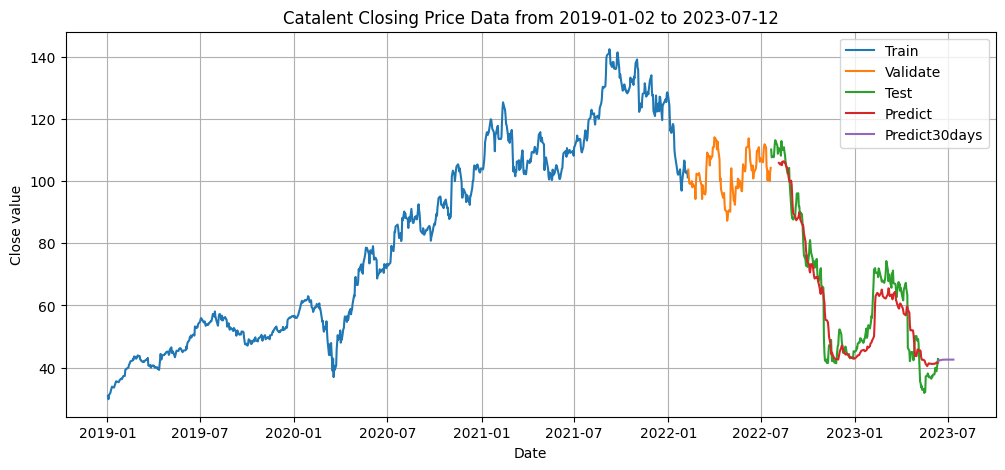

In [21]:
plt.figure(figsize=(12, 5))

plt.plot(df.index[:train_size], scaler.inverse_transform(train_data))

plt.plot(df.index[train_size : train_size + val_size], scaler.inverse_transform(val_data))

plt.plot(df.index[train_size + val_size : ], scaler.inverse_transform(test_data))

plt.plot(df.index[train_size + val_size + best_window_size + 1: ], best_y_pred)

plt.plot(index_next_30_days, scaler.inverse_transform(np.array(y_next_30_days).reshape(-1, 1)))

plt.legend(['Train', 'Validate', 'Test', 'Predict', 'Predict30days'])

plt.grid()
plt.title(f"Catalent Closing Price Data from {df.index[0].strftime('%Y-%m-%d')} to {index_next_30_days[-1].strftime('%Y-%m-%d')}")
plt.xlabel("Date")
plt.ylabel("Close value")
plt.savefig('TCAN_712_CTLT.png')
plt.show()